In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('dating_data.csv')
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [5]:
df.shape[0]

14514

В качестве основной метрики возьмем число любых действий пользователя. Мы хотим увеличить это число.

В качестве прокси метрики будем считать долю лайков пользователя ко всем просмотренным им анкетам.
(вторым разумным кандидатом было отношение взаимных лайков ко всем лайкнутым пользователям, однако тут две группы сильно переплетены: взаимный лайк для пользователей из разных групп оказывается в результате работы разных алгоритмов. Взаимные лайки для пользователей только из одной группы плохо, смотреть, потому что пользователь лайкал также людей из противоположной группы. Для проведения такого теста надо провести АА тестирование, чтобы понять, что пользователям нравится одинаковое количество пользователей из разных групп вне зависимости от алгоритма)

Поймем, что мы правильно понимаем, что group указывается для user_id_1

In [8]:
df.groupby(['user_id_1', 'group'], as_index=False).agg({'is_match':'sum'}).shape[0] == df.groupby(['user_id_1'], as_index=False).agg({'is_match':'sum'}).shape[0]

True

Выделим пользователей со взаимными лайками (для результатов теста они нам не пригодятся)

In [11]:
gf = df.rename(columns={'user_id_1':'user_id_2', 'user_id_2':'user_id_1'})

In [15]:
df.merge(gf, on=['user_id_2', 'user_id_1', 'is_match']).query("is_match == 1")

,user_id_1,user_id_2,group_x,is_match,group_y
0,416,676,1,1,1
11,183,625,0,1,0
12,238,186,1,1,1
20,976,526,1,1,1
23,562,876,1,1,1
...,...,...,...,...,...
247,393,512,1,1,1
250,177,890,1,1,1
263,220,294,1,1,1
271,533,596,0,1,0


In [17]:
df['is_match_2'] = df['is_match']

In [22]:
gf = df.groupby('user_id_1', as_index=False).agg({'group':'max', 'is_match':'sum', 'is_match_2':'count'})

In [23]:
gf = gf.rename(columns={'is_match':'sum_of_likes', 'is_match_2':'cnt_of_actions'})

In [25]:
gf['likes_to_actions'] = gf['sum_of_likes'] / (gf['sum_of_likes'] + gf['cnt_of_actions'])

In [26]:
gf.head()

,user_id_1,group,sum_of_likes,cnt_of_actions,likes_to_actions
0,1,1,11,24,0.314286
1,2,1,7,16,0.304348
2,3,1,5,16,0.238095
3,4,0,2,9,0.181818
4,5,1,13,22,0.371429


In [28]:
gf_control = gf.query("group == 0")

In [29]:
gf_test = gf.query("group == 1")

In [30]:
from scipy import stats
stats.shapiro(gf_control.cnt_of_actions)

ShapiroResult(statistic=0.9884836673736572, pvalue=0.00055683683604002)

Распредление отличается от нормального на любом разумном уровне значимости. 
Посмотрим на график распредления

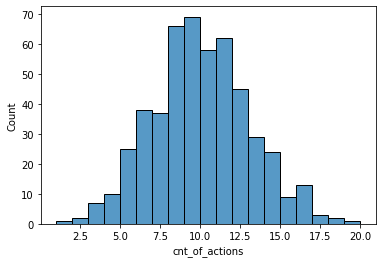

In [31]:
sns.histplot(gf_control.cnt_of_actions)

Логарифм тут не поможет. Просто тест на нормальность очень чувствительный. Воспользуемся критерием Манна Уитни

In [34]:
from scipy.stats import mannwhitneyu
stats.mannwhitneyu(gf_control.cnt_of_actions, gf_test.cnt_of_actions)

MannwhitneyuResult(statistic=3316.0, pvalue=6.905154965510583e-157)

Гипотезу о том, что выборки одинаковы мы отвергаем на любом значимом уровне.

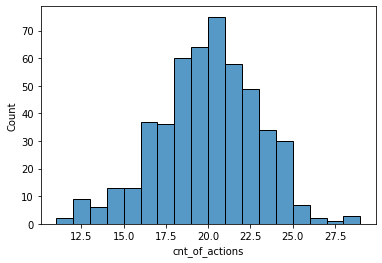

In [35]:
sns.histplot(gf_test.cnt_of_actions)

Как представители выборок вполне подойдет среднее и медиана

In [36]:
gf_control.cnt_of_actions.mean()

9.564870259481038

In [37]:
gf_test.cnt_of_actions.mean()

19.482965931863728

In [38]:
gf_control.cnt_of_actions.median()

9.0

In [39]:
gf_test.cnt_of_actions.median()

20.0

И по медиане и по среднему новый алгоритм показывает себя лучше старого. Отсюда делаем вывод о том, что на уровне 5\%(будем счиать, что об этом уровне и о количестве участников мы договорились заранее) новый алгоритм лучше старого

Однако проверим гипотизу и для неосновной метрики

In [40]:
stats.shapiro(gf_control.likes_to_actions)

ShapiroResult(statistic=0.9634589552879333, pvalue=7.898490195223928e-10)

In [41]:
stats.shapiro(gf_test.likes_to_actions)

ShapiroResult(statistic=0.9827184677124023, pvalue=1.18711559480289e-05)

Эти распредления не являются нормальными

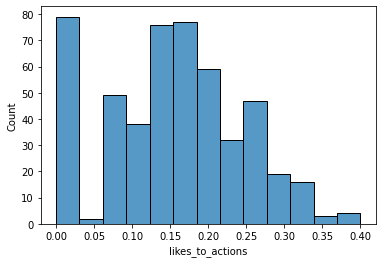

In [42]:
sns.histplot(gf_control.likes_to_actions)

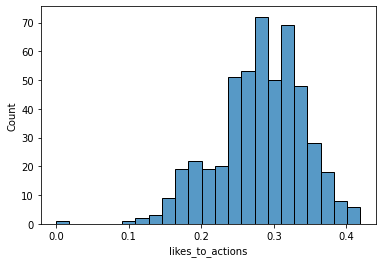

In [43]:
sns.histplot(gf_test.likes_to_actions)

In [44]:
stats.mannwhitneyu(gf_test.likes_to_actions, gf_control.likes_to_actions)

MannwhitneyuResult(statistic=220237.0, pvalue=1.0739285895805636e-96)

Распределения не одинаковы на любом разумном уровне значимости

In [45]:
gf_test.likes_to_actions.median()

0.2857142857142857

In [46]:
gf_control.likes_to_actions.median()

0.15384615384615385

In [47]:
gf_test.likes_to_actions.mean()

0.28210691035505275

In [48]:
gf_control.likes_to_actions.mean()

0.15223888265442723

И в этой метрике новый алгоритм показал себя лучше на уровне значимости 5\%

Вывод: заменить старый алгоритм на новый алгоритм